# **New York Yellow Taxi Demand Analysis**


New York taxi(yellow and green) are widely recognizable symbols of New York City. Yellow Taxi Cabs are able to pick passengers from anywhere in the five boroughs, where as Green Taxi Cabs which are known as boro cabs can pick passengers from Upper Manhattan, the Bronx, Brooklyn, Queens (excluding LaGuardia Airport and John F. Kennedy International Airport), and Staten Island.
The taxicabs work privately and are licenced to work by the New York Taxi and Limousine Commission(TLC). 

Due to increase in competition with app based cab services such as UBER, LYFT etc., this traditional call based service faces problems in terms of placing drivers at areas such that people can easily have access to the cabs. TLC communication started releasing the data every year so that people can analyze the demand and thus have a better placement of the cabs.

This study provides a statistical breakdown of Taxi Demand based January 2018 data for TLC Yellow Cabs. The collective graphs and tables were designed to inform taxi drivers of the demand profile for rides in terms of pickup and dropoff locations. A series of forecasting models to predict future demand have been included in order to characterize the recurrency of weekly taxi ridership for the entire NYC area as well as for each Borough.

## Importing all the necessary Libraries

* First of all, lets begin by installing all the required libraries.



In [1]:
!pip install --upgrade 'google-cloud-bigquery[bqstorage,pandas]'
!pip install -U scikit-learn
!pip install statsmodels
!pip install pmdarima
!pip install prophet
!pip install xgboost

     |████████████████████████████████| 23.2 MB 133 kB/s 
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1
     |████████████████████████████████| 1.4 MB 4.0 MB/s 
     |████████████████████████████████| 9.8 MB 11.9 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2
     |████████████████████████████████| 65 kB 2.3 MB/s 
     |████████████████████████████████| 49 kB 5.3 MB/s 
     |████████████████████████████████| 214 kB 9.1 MB/s 
  Created wheel for prophet: filename=prophet-1.0.1-py3-none-any.whl size=6640303 sha256=db691bf23f4de801668e762828b86148efee3d1bbb86d8b83888866075570214
  Stored in directory: /root/.cache/pip/wheels/4e/a0/1a/02c9ec9e3e9de6bdbb3d769d11992a6926889d71567d6b9b67
Successfully built prophe

* Let's import all the necessary libraries required for forecasting, plotting and characterising the data. 

In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
from google.cloud import bigquery
from google.oauth2 import service_account
import matplotlib.pyplot as plt
from datetime import datetime,timedelta
import time
from sklearn.preprocessing import RobustScaler
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers import Bidirectional
from sklearn.metrics import mean_absolute_percentage_error
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.api import SARIMAX 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from prophet import Prophet

## Querying the data from BigQuery


* Big Query is a service from the Google Cloud Platform and works in a similar way to a regular SQL server where you can query the data based on your conditions.
* Here, we query the data based on simple checks on trip distance, fare amount, and the transactions between 1st Jan 2018- 28th Jan 2018.
* The maximum allowed passenger count is 5 for the taxis so this will also be a good filter to remove incorrect datapoints.

In [3]:
key_path = "/content/taxi-data-325615-88120fc253ba.json" #you need to put your own key to access the data from big query.

credentials = service_account.Credentials.from_service_account_file(
    key_path, scopes=["https://www.googleapis.com/auth/cloud-platform"],
)

bqclient = bigquery.Client(credentials=credentials, project=credentials.project_id,)
query_string = """
SELECT pickup_datetime,dropoff_datetime,passenger_count,trip_distance, total_amount,pickup_location_id, dropoff_location_id FROM `bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_2018` 
WHERE
(
trip_distance > 0
and fare_amount > 0
and (pickup_datetime >='2018-01-01' and pickup_datetime<'2018-01-29')
and passenger_count <=5
)
LIMIT 1000000
"""
df = (
    bqclient.query(query_string).result().to_dataframe()
)
df.head()

,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,total_amount,pickup_location_id,dropoff_location_id
0,2018-01-21 12:45:54,2018-01-21 13:15:31,2,5.6,27.37,25,72
1,2018-01-22 07:43:36,2018-01-22 09:07:10,5,13.9,68.28,244,88
2,2018-01-22 11:55:06,2018-01-22 12:23:18,1,9.26,43.87,209,123
3,2018-01-21 08:37:32,2018-01-21 08:54:25,1,7.47,27.96,74,234
4,2018-01-21 18:35:16,2018-01-21 19:10:09,1,10.4,42.35,256,42


## Determine the Pickup and Dropoff locations 

* One of the most important factors for the taxis is the pickup and dropoff locations. 
* In the queried data, the pickup and dropoff locations are in integers and we have to use the taxi-zone lookup table released by TLC to find out the actual pickup and dropoff locations and other additional information as well.
* We first read the data using pandas and join both the dataframes to find out the pickup and dropoff locations.

In [4]:
df2=pd.read_csv('taxi+_zone_lookup.csv')
df2['LocationID']=df2['LocationID'].apply(lambda x: str(x))
merged_doc= pd.merge(df,df2,how='inner',left_on='pickup_location_id',right_on='LocationID')
merged_doc=merged_doc.rename(columns={'Borough':'Pickup_Borough','Zone':'Pickup_Zone','service_zone':'Pickup_service_zone'})
merged_doc.pop('LocationID')
merged_doc= pd.merge(merged_doc,df2,how='inner',left_on='dropoff_location_id',right_on='LocationID')
merged_doc=merged_doc.rename(columns={'Borough':'Dropoff_Borough','Zone':'Dropoff_Zone','service_zone':'Dropoff_service_zone'})
merged_doc.pop('LocationID')
merged_doc.head()

,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,total_amount,pickup_location_id,dropoff_location_id,Pickup_Borough,Pickup_Zone,Pickup_service_zone,Dropoff_Borough,Dropoff_Zone,Dropoff_service_zone
0,2018-01-21 12:45:54,2018-01-21 13:15:31,2,5.6,27.37,25,72,Brooklyn,Boerum Hill,Boro Zone,Brooklyn,East Flatbush/Remsen Village,Boro Zone
1,2018-01-05 21:41:37,2018-01-05 22:14:45,1,5.04,24.3,25,72,Brooklyn,Boerum Hill,Boro Zone,Brooklyn,East Flatbush/Remsen Village,Boro Zone
2,2018-01-06 05:09:52,2018-01-06 05:29:41,1,5.41,23.76,256,72,Brooklyn,Williamsburg (South Side),Boro Zone,Brooklyn,East Flatbush/Remsen Village,Boro Zone
3,2018-01-14 20:23:00,2018-01-14 20:57:24,1,6.4,29.8,256,72,Brooklyn,Williamsburg (South Side),Boro Zone,Brooklyn,East Flatbush/Remsen Village,Boro Zone
4,2018-01-06 02:45:51,2018-01-06 03:40:54,1,16.8,54.3,116,72,Manhattan,Hamilton Heights,Boro Zone,Brooklyn,East Flatbush/Remsen Village,Boro Zone


* We now have the basic data required to start with our analysis.
* The next few sections will present several graphs which will provide necessary insights, help us in removing the outliers and filter our data before creating the forecasting models. 

## Finding outliers and filtering the data 

* As with any prediction model, the quality of prediction depends on the data that you give as input to the model.
* Also, as the data queried is sometimes extraneous due to incorrect data entry and needs to be filtered before drawing out any conclusions.
* As we already put simple checks while querying the data we will now go ahead and consider factors like trip distance, speed and the overall ride time to remove the outliers. 
  

*Here we use the dropff and pickup time to find the ride time for different pickups*
*As per the rules, maximum ride time is allowed to be 12 hrs for taxi cabs and cannot excede that.*

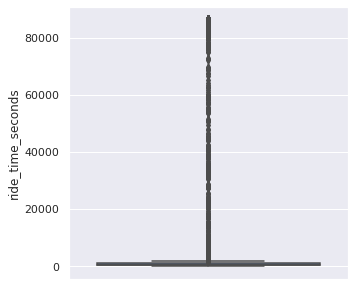

In [5]:
merged_doc['ride_time']=merged_doc['dropoff_datetime']-merged_doc['pickup_datetime']
merged_doc['ride_time_seconds']=merged_doc['ride_time'].apply(lambda x: int(x.total_seconds())) #calculating the ridetime in seconds so that its easy to compare.
merged_doc=merged_doc[(merged_doc['ride_time_seconds'] > 0)] # check for having ride time to be positive as it can be negative due to incorrect data.
sns.set(rc={'figure.figsize':(5,5)})
sns.boxplot(y="ride_time_seconds",data=merged_doc,orient='v') #We create a box plot to see the distribution of data.

* As you can see, the data is distributed such that there are a few data points with values around 20+ hrs. 
* Diving further into the values to identify the outliers 

In [6]:
quantile_ridetime = merged_doc.ride_time.quantile(np.round(np.arange(.9, 1.01, 0.01), 3))
qValues = np.round(np.arange(0.9, 1.01, 0.01), 3)
for i in qValues:
    print("{}th percentile value of Trip Duration is {}min".format((i*100), quantile_ridetime[i]))
print("*"*40)
quantile_ridetime = merged_doc.ride_time.quantile(np.round(np.arange(.99, 1.001, 0.001), 3))
qValues = np.round(np.arange(0.99, 1.001, 0.001), 3)
for i in qValues:
    print("{}th percentile value of Trip Duration is {}".format((i*100), quantile_ridetime[i]))

90.0th percentile value of Trip Duration is 0 days 00:26:43min
91.0th percentile value of Trip Duration is 0 days 00:27:50min
92.0th percentile value of Trip Duration is 0 days 00:29:09min
93.0th percentile value of Trip Duration is 0 days 00:30:39min
94.0th percentile value of Trip Duration is 0 days 00:32:26min
95.0th percentile value of Trip Duration is 0 days 00:34:32min
96.0th percentile value of Trip Duration is 0 days 00:37:10min
97.0th percentile value of Trip Duration is 0 days 00:40:45min
98.0th percentile value of Trip Duration is 0 days 00:46:10min
99.0th percentile value of Trip Duration is 0 days 00:56:21min
100.0th percentile value of Trip Duration is 0 days 23:59:57min
****************************************
99.0th percentile value of Trip Duration is 0 days 00:56:21
99.1th percentile value of Trip Duration is 0 days 00:58:01
99.2th percentile value of Trip Duration is 0 days 00:59:54
99.3th percentile value of Trip Duration is 0 days 01:02:10
99.4th percentile value o

* From the above analysis, we see that 2 hrs contibutes to 98th percentile of all the ride times and is reasonable as well.
* So, we filter out the data with ridetimes greater than this value.

In [7]:
merged_doc=merged_doc[(merged_doc['ride_time_seconds'] > 0) & (merged_doc['ride_time_seconds']<(2*3600))]

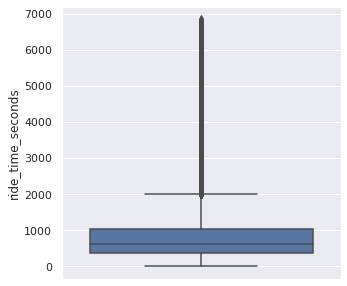

In [8]:
sns.boxplot(y="ride_time_seconds",data=merged_doc,orient='v')

* The distribution now is much more reasonable with ridetimes around 2 hrs maximum with most of the rides lasting for 15mins.


*Doing a similar analysis for speed of the taxis.*

*This will take care of the ride distance being unresonable since we already have filtered the ride times.*

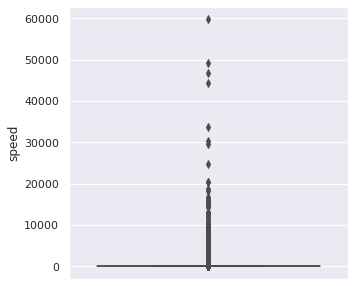

In [9]:
merged_doc['speed']= merged_doc['trip_distance']/merged_doc['ride_time_seconds']*3600
merged_doc['speed']=merged_doc['speed'].apply(lambda x: int(x))
sns.boxplot(y="speed",data=merged_doc,orient='v')

* We see the distribution for the speed is completely irrelevant as well owing to outliers with speed values around 60000. This is mostly because of trip distance being unnecessarily high despite having small trip time. 

In [10]:
quantile_speed = merged_doc.speed.quantile(np.round(np.arange(0.9, 1.01, 0.01), 3))
qValues = np.round(np.arange(0.9, 1.01, 0.01), 3)
for i in qValues:
    print(f"{i*100}th percentile value of the speed is {quantile_speed[i]}")
print("*"*40)
quantile_speed = merged_doc.speed.quantile(np.round(np.arange(0.99, 1.001, 0.001), 3))
qValues = np.round(np.arange(0.99, 1.001, 0.001), 3)
for i in qValues:
    print(f"{i*100}th percentile value of the speed is {quantile_speed[i]}")

90.0th percentile value of the speed is 19.0
91.0th percentile value of the speed is 20.0
92.0th percentile value of the speed is 21.0
93.0th percentile value of the speed is 22.0
94.0th percentile value of the speed is 23.0
95.0th percentile value of the speed is 24.0
96.0th percentile value of the speed is 26.0
97.0th percentile value of the speed is 28.0
98.0th percentile value of the speed is 31.0
99.0th percentile value of the speed is 35.0
100.0th percentile value of the speed is 59760.0
****************************************
99.0th percentile value of the speed is 35.0
99.1th percentile value of the speed is 35.0
99.2th percentile value of the speed is 36.0
99.3th percentile value of the speed is 37.0
99.4th percentile value of the speed is 38.0
99.5th percentile value of the speed is 39.0
99.6th percentile value of the speed is 40.0
99.7th percentile value of the speed is 41.0
99.8th percentile value of the speed is 43.0
99.9th percentile value of the speed is 50.0
100.0th pe

* Removing speeds which are more than 50 miles/hr which correspond to .1% of the data and are unreasonable. 

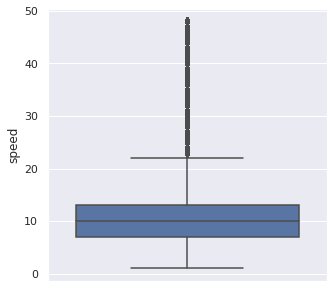

In [11]:
merged_doc=merged_doc[(merged_doc['speed'] > 0) & (merged_doc['speed']<(50))]
sns.boxplot(y="speed",data=merged_doc,orient='v')

* Now we have a much better distribution with most speed values ranging from 7 to 15 miles/hr with maximum speed being around 50 miles /hr.
* This value is reasonable considering we are doing an analysis on yellow taxi cabs which mostly drive in cities.

## Visualizing the density of Pickups for different Boroughs

* Since we have data with Pickup and Dropoff Boroughs, we will now try to characterize the pickups and dropoffs based on the boroughs to see the density of pickup and dropoff happening in these regions.  

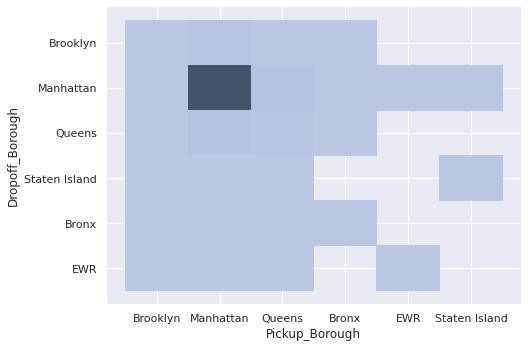

In [12]:
boroughs= merged_doc.groupby(['Pickup_Borough','Dropoff_Borough']).agg({'passenger_count':['count']})
boroughs.columns=['total_passenger_count']
sns.displot(x=merged_doc.Pickup_Borough,y=merged_doc.Dropoff_Borough,height=5, aspect=1.5)

* This plot gives you an idea of the density of pickups and dropoffs happening across different boroughs.
* Maximum number of pickups and dropsoffs are happening between Manhattan followed by all the pairs possible between Manhattan, Brooklyn and Queens. 
* This data is consistent with the fact that Brooklyn has the highest population followed by Queens and Manhattan. Manhattan being accessable from both the Borough and being the centre of Economy for the region.   
* Bronx follows this trend having highest density after the first 3 and Staten island is last.

**Looking at the actual values for the number of pickups** 

In [13]:
boroughs

total_passenger_count
Pickup_Borough Dropoff_Borough                       
Bronx          Bronx                              494
               Brooklyn                             7
               Manhattan                          225
               Queens                              17
Brooklyn       Bronx                               30
               Brooklyn                          7697
               EWR                                  9
               Manhattan                         3192
               Queens                             647
               Staten Island                        9
EWR            EWR                                  7
               Manhattan                            5
Manhattan      Bronx                             4646
               Brooklyn                         26517
               EWR                               1642
               Manhattan                       836881
               Queens                           30549
               Staten Island                      145
Queens         Bronx                             1049
               Brooklyn                          9239
               EWR                                 59
               Manhattan                        38403
               Queens                           15224
               Staten Island                       58
Staten Island  Manhattan                            2
               Staten Island                        7

* As you can see, Staten island and Bronx contribute only around 1% of the total pickups and hence we dont have enough datapoints to do an accurate demand prediction for these areas. 
* Hence, we will not consider the pickups and dropoffs from these 2 boroughs. 

### Segregating based on the Broughs

* We pick the data with pickups and dropoffs from Manhattan, Queens and Brooklyn.

In [14]:
Boroughs=['Manhattan','Queens','Brooklyn']
merged_doc=merged_doc[merged_doc['Pickup_Borough'].isin(Boroughs)]
merged_doc=merged_doc[merged_doc['Dropoff_Borough'].isin(Boroughs)]

**The Percentage of Data removing after filtering for outliers and Boroughs:**

In [15]:
print(f"The percent of data after removal:{len(merged_doc)/len(df)*100}")

The percent of data after removal:96.8349


## Data Analysis for Taxi Cab Demand

* Now we present a few graphs which will help us in identifying seasonality, trends, etc.
* Segregating pickup datetimes into different components

In [16]:
merged_doc['pickup_time']=merged_doc['pickup_datetime'].dt.time
merged_doc['pickup_date']=merged_doc['pickup_datetime'].dt.date
merged_doc['pickup_hour']=merged_doc.pickup_datetime.dt.hour
merged_doc['day_of_week']=merged_doc['pickup_datetime'].dt.dayofweek
merged_doc['day_of_month']=merged_doc['pickup_datetime'].dt.day
merged_doc['pickup_week']=merged_doc['pickup_datetime'].dt.isocalendar().week

In [17]:
merged_doc.head()

,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,total_amount,pickup_location_id,dropoff_location_id,Pickup_Borough,Pickup_Zone,Pickup_service_zone,Dropoff_Borough,Dropoff_Zone,Dropoff_service_zone,ride_time,ride_time_seconds,speed,pickup_time,pickup_date,pickup_hour,day_of_week,day_of_month,pickup_week
0,2018-01-21 12:45:54,2018-01-21 13:15:31,2,5.6,27.37,25,72,Brooklyn,Boerum Hill,Boro Zone,Brooklyn,East Flatbush/Remsen Village,Boro Zone,0 days 00:29:37,1777,11,12:45:54,2018-01-21,12,6,21,3
1,2018-01-05 21:41:37,2018-01-05 22:14:45,1,5.04,24.3,25,72,Brooklyn,Boerum Hill,Boro Zone,Brooklyn,East Flatbush/Remsen Village,Boro Zone,0 days 00:33:08,1988,9,21:41:37,2018-01-05,21,4,5,1
2,2018-01-06 05:09:52,2018-01-06 05:29:41,1,5.41,23.76,256,72,Brooklyn,Williamsburg (South Side),Boro Zone,Brooklyn,East Flatbush/Remsen Village,Boro Zone,0 days 00:19:49,1189,16,05:09:52,2018-01-06,5,5,6,1
3,2018-01-14 20:23:00,2018-01-14 20:57:24,1,6.4,29.8,256,72,Brooklyn,Williamsburg (South Side),Boro Zone,Brooklyn,East Flatbush/Remsen Village,Boro Zone,0 days 00:34:24,2064,11,20:23:00,2018-01-14,20,6,14,2
4,2018-01-06 02:45:51,2018-01-06 03:40:54,1,16.8,54.3,116,72,Manhattan,Hamilton Heights,Boro Zone,Brooklyn,East Flatbush/Remsen Village,Boro Zone,0 days 00:55:03,3303,18,02:45:51,2018-01-06,2,5,6,1


### Hourly pickup demand for the week accross all the Boroughs

**Total Demand across all the Boroughs for differnt weeks for different hours**

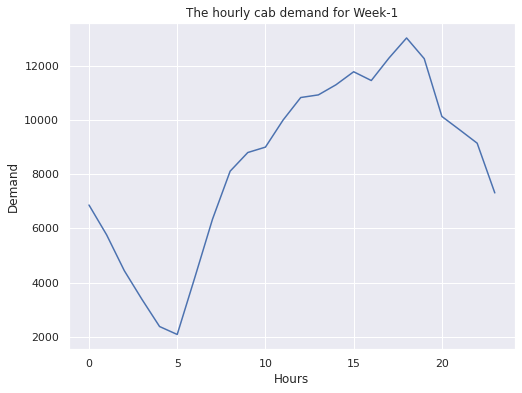

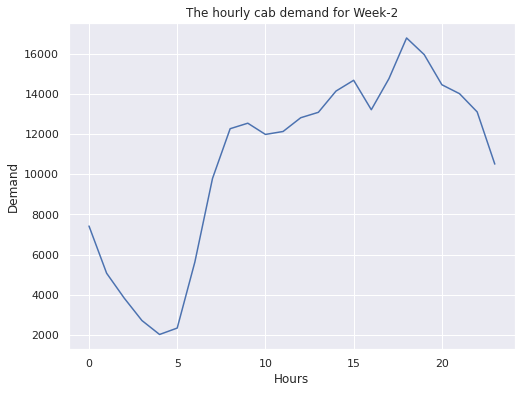

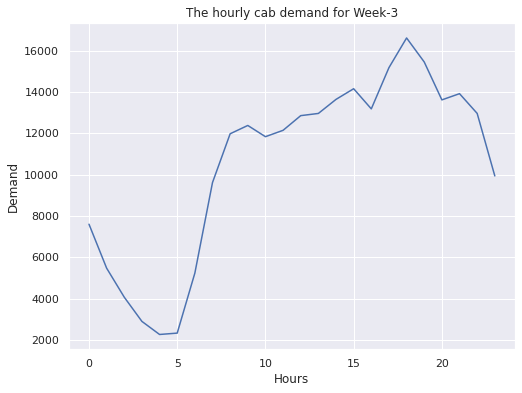

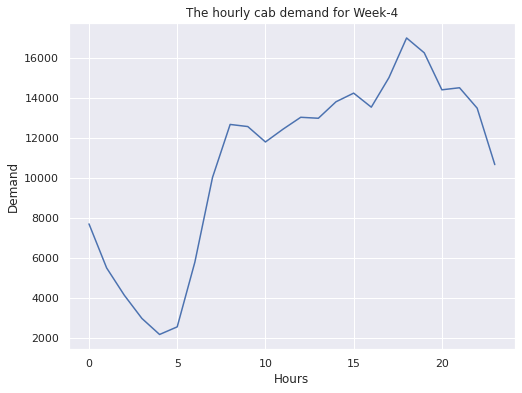

In [18]:
week_hr_pickup=merged_doc.groupby(['pickup_week','pickup_hour']).agg({'passenger_count':'count'})
week_hr_pickup.columns=['hourly_demand']
week_hr_pickup=week_hr_pickup.reset_index()
%matplotlib inline
for i in set(week_hr_pickup['pickup_week']):
  test= week_hr_pickup[week_hr_pickup['pickup_week']==i]
  fig = plt.figure(figsize = (8, 6))
  plt.plot(test['pickup_hour'],test['hourly_demand'])
  plt.title(f"The hourly cab demand for Week-{i}")
  plt.xlabel("Hours")
  plt.ylabel("Demand")

* We can see there is a definite trend across all the weeks with total demand falling till 5am and then rising during the peak hours, maximum being around 5-6 pm and then reducing again. 
* The total demand is less in the first week which could be attributed to the fact that its after an holiday period and people take time to get back to work.
* But this demand is heavily biased towards demand coming from Manhattan, while other boroughs contributing less. So, we also find the aggregate demand for the individual Boroughs across different weeks. 

### Agg Hourly Pickup Demand for different Boroughs across weeks


**Demand for Individual Boroughs across different weeks**

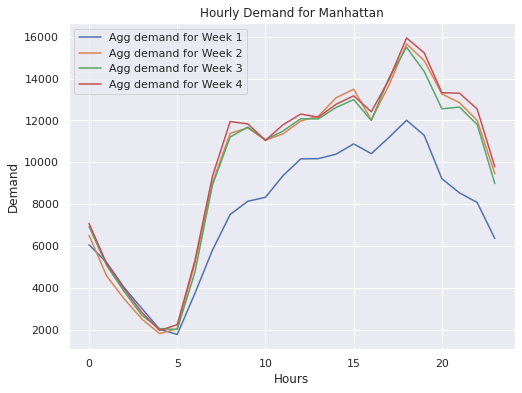

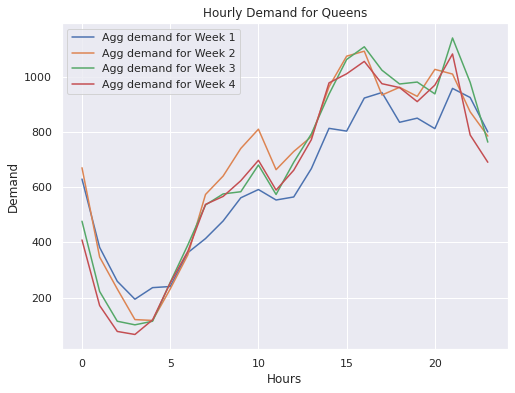

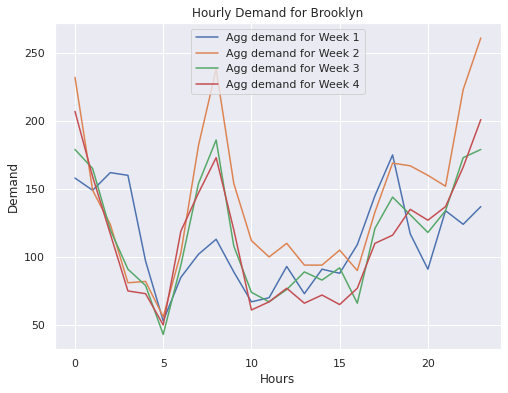

In [19]:
pickup_df= merged_doc.groupby(['Pickup_Borough','pickup_week','pickup_hour']).agg({'passenger_count':'count'})
pickup_df.columns=['hourly_demand']
pickup_df=pickup_df.reset_index()
for j in set(pickup_df['Pickup_Borough']):
  fig = plt.figure(figsize = (8, 6))
  test= pickup_df[pickup_df['Pickup_Borough']==j]
  for i in set(test['pickup_week']):
    test2=test[test['pickup_week']==i]
    plt.plot(test2['pickup_hour'],test2['hourly_demand'],label=f"Agg demand for Week {i}")
  plt.legend()
  plt.title(f"Hourly Demand for {j}")
  plt.xlabel("Hours")
  plt.ylabel("Demand")

* Here, as you can see all the Boroughs have a weekly trend but the number of pickups in manhattan being significantly higher than that of Brooklyn and Queens.
* However its interesting to note that the demand follows a trend across all weeks which can be useful in determining features for making predictions.
* Diving deep into daily demand trends for the weeks.


### Daily demand for various weeks

**Daily demand for different weeks for different Boroughs**

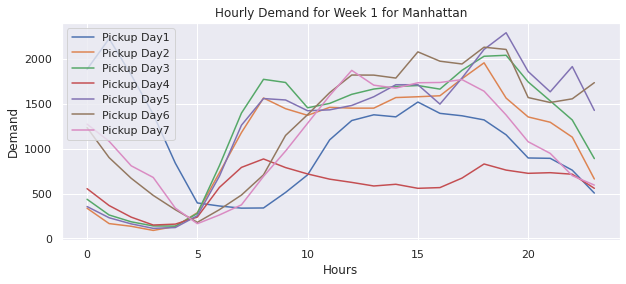

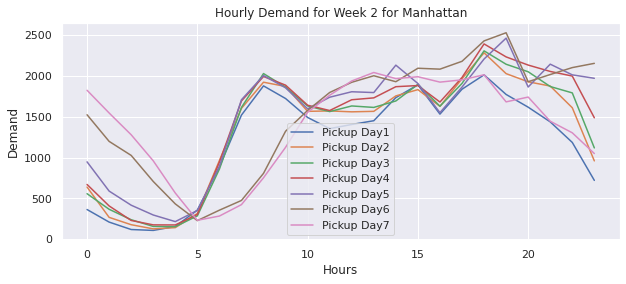

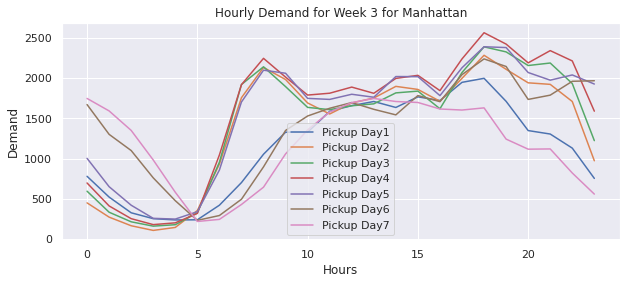

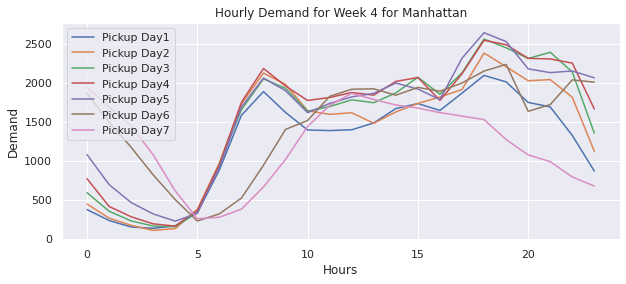

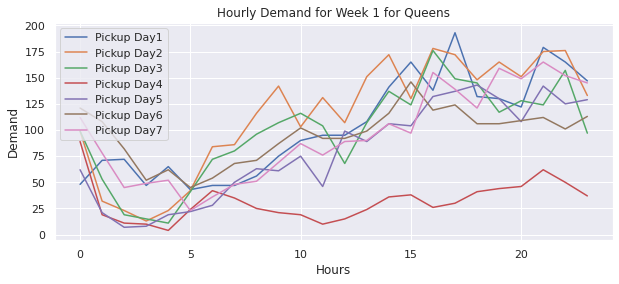

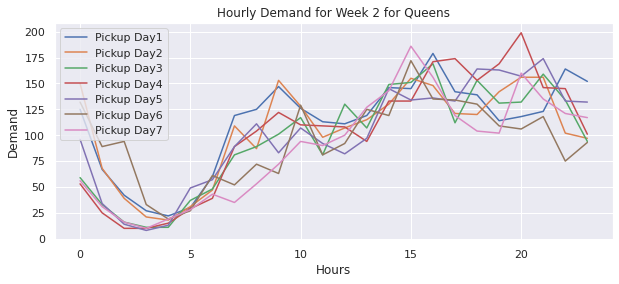

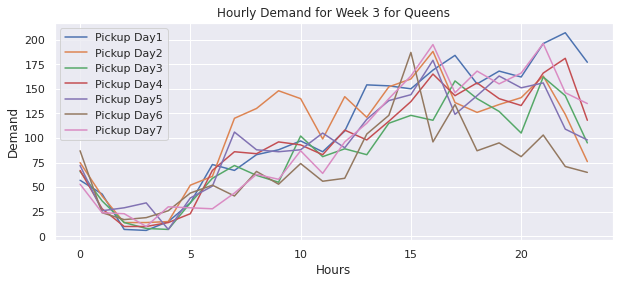

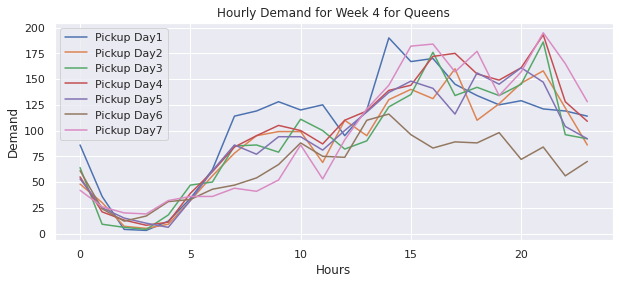

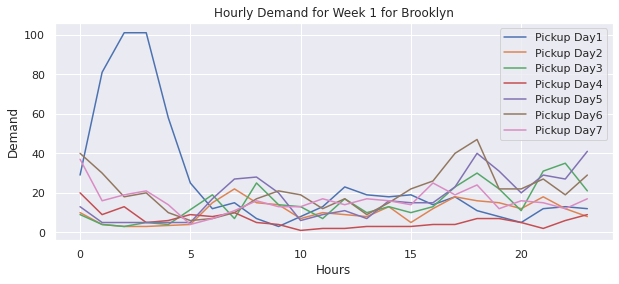

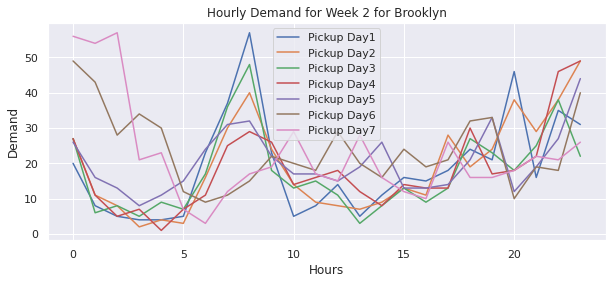

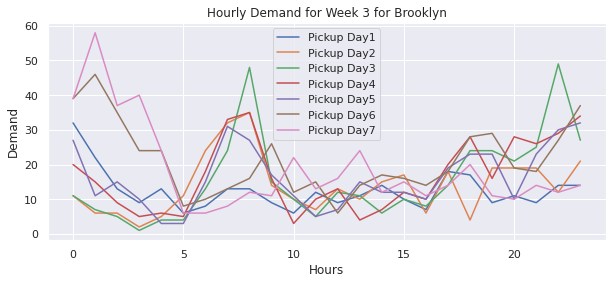

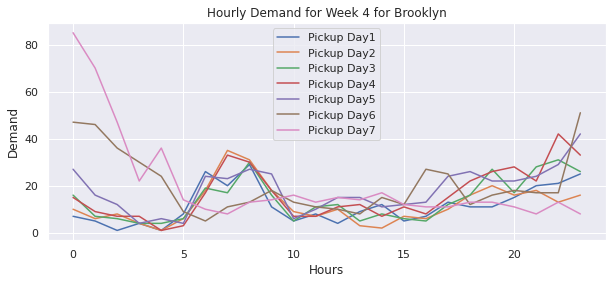

In [20]:
pickup_df_day= merged_doc.groupby(['Pickup_Borough','pickup_week','day_of_week','pickup_hour']).agg({'passenger_count':'count'})
pickup_df_day.columns=['hourly_demand']
pickup_df_day=pickup_df_day.reset_index()
for m in set(pickup_df_day['Pickup_Borough']):
  for i in set(pickup_df_day['pickup_week']):
    fig = plt.figure(figsize = (10, 4))
    test= pickup_df_day[pickup_df_day['pickup_week']==i]
    test= test[test['Pickup_Borough']==m]
    for j in set(test['day_of_week']):
      test2=test[test['day_of_week']==j]
      plt.plot(test2['pickup_hour'],test2['hourly_demand'],label=f"Pickup Day{j+1}")
    plt.legend()
    plt.title(f"Hourly Demand for Week {i} for {m}")
    plt.xlabel("Hours")
    plt.ylabel("Demand")

* This plot is significant as it shows us the daily trend that is followed in terms of demand across all the Boroughs.
* Thus the pickup hour plays a significant role in deciding the demand for the day and can be a good factor.
* Similarly pickup day can also be a good factor to consider during feature engineering as similar trend is followed on the same day across different weeks.


###Pickup Demand curve for the Whole month

**Showing the daily demand for the whole month for different Boroughs** 

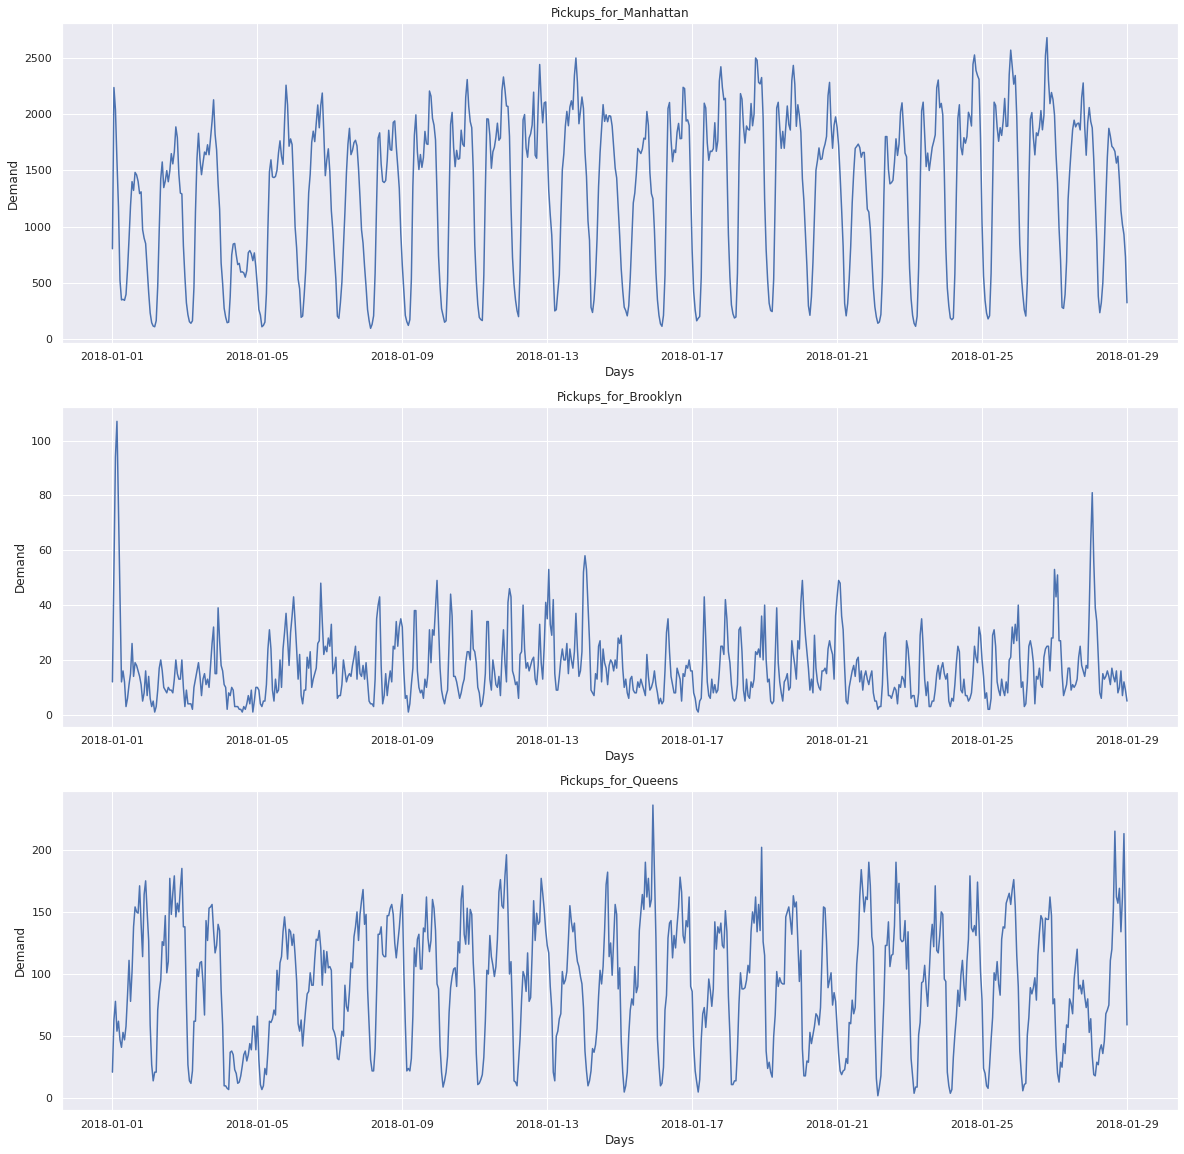

In [107]:
Boroughs=['Manhattan','Brooklyn','Queens']
Borough_pickups={}
for Borough in Boroughs:
  Borough_pickups[Borough]= merged_doc[merged_doc['Pickup_Borough']==Borough]
  Borough_pickups[Borough]= Borough_pickups[Borough].assign(pickup_datetime=Borough_pickups[Borough].pickup_datetime.dt.round('H'))
  Borough_pickups[Borough]= Borough_pickups[Borough].groupby(['pickup_datetime']).agg({'passenger_count':'count'})
  Borough_pickups[Borough].columns=['hourly_demand']
  Borough_pickups[Borough]=Borough_pickups[Borough].reset_index()

i=0
fig, ax = plt.subplots(3,1,figsize=(20,20))
for Borough in Borough_pickups:
  ax[i].plot(Borough_pickups[Borough].pickup_datetime,Borough_pickups[Borough].hourly_demand)
  ax[i].set_xlabel("Days")
  ax[i].set_ylabel("Demand")
  ax[i].set_title(f"Pickups_for_{Borough}")
  i+=1

* Now that we have a good idea about the trend and the seasonality across different weeks, we can go ahead and start creating prediction models to assist with Forecasting.

## Using Arima model for prediction

* We will use Arima as a base model for forecasting. We will use the data of the first 3 weeks as training data and predict the demand for the 4th week.
* Before creating the models we will divide the dataframe into pickups for different boroughs and store them in a dictionary.


In [ ]:
Boroughs=['Manhattan','Brooklyn','Queens']
Borough_pickups_arima={}
for Borough in Boroughs:
  Borough_pickups_arima[Borough]= merged_doc[merged_doc['Pickup_Borough']==Borough]
  Borough_pickups_arima[Borough]= Borough_pickups_arima[Borough].assign(pickup_datetime=Borough_pickups_arima[Borough].pickup_datetime.dt.round('H'))
  Borough_pickups_arima[Borough]= Borough_pickups_arima[Borough].groupby(['pickup_datetime']).agg({'passenger_count':'count'})
  Borough_pickups_arima[Borough].columns=['hourly_demand']
  Borough_pickups_arima[Borough]=Borough_pickups_arima[Borough].reset_index()
  Borough_pickups_arima[Borough].index= Borough_pickups_arima[Borough]['pickup_datetime']
  Borough_pickups_arima[Borough].pop('pickup_datetime')


* Arima is a statistical model which uses auto regressor, moving average and integrated properties to determine the future values from a series of past ones. 
* To successfully use ARIMA, we have to first if the series we are checking for is stationary or not. We will plot different statistics to check the stationarity of the series or if there is a trend in the data.

In [ ]:
def print_statistics(Borough_pickups):
  for Borough in Borough_pickups:
    df_test= adfuller(Borough_pickups[Borough]['hourly_demand'])
    print(f"Test Statistic for {Borough}: {df_test[0]}")
    print(f"P-value for {Borough}: {df_test[1]}")
    print(f"Critial Values for {Borough}:")
    for key, value in df_test[4].items():
      print(f'{key}, {value}') 
    print("*"*30)
print_statistics(Borough_pickups_arima)

Test Statistic for Manhattan: -3.1688615020533795
P-value for Manhattan: 0.02185934176762056
Critial Values for Manhattan:
1%, -3.440419374623044
5%, -2.865983079837035
10%, -2.5691361169972526
******************************
Test Statistic for Brooklyn: -5.058591910109669
P-value for Brooklyn: 1.697114011219218e-05
Critial Values for Brooklyn:
1%, -3.4404504809576695
5%, -2.8659967824852073
10%, -2.569143417751479
******************************
Test Statistic for Queens: -3.214536358385521
P-value for Queens: 0.019158526629759563
Critial Values for Queens:
1%, -3.440419374623044
5%, -2.865983079837035
10%, -2.5691361169972526
******************************


* As we can see the P-value for the data is less than .05 for adfuller test which means that we can ignore the null hypothesis and assume that the data is stationary.
* We also plot the PACF and ACF plots to understand what model can give us a good result. 

In [ ]:
def plot_stats_pickups(datasets):
  for Borough in datasets:
    print(f"Plotting the stats for {Borough}")
    X = np.array(datasets[Borough]['hourly_demand'])
    fig, ax = plt.subplots(2,2, figsize=(15,9), gridspec_kw = {'wspace':0.2, 'hspace':0.4})

    ax[0,0].plot(X)
    ax[0,0].set_title('Original Data')

    ax[0,1].hist(X)
    ax[0,1].set_title('Histogram')

    sm.graphics.tsa.plot_acf(X, lags=7, ax=ax[1,0])
    sm.graphics.tsa.plot_pacf(X, lags=7, ax=ax[1,1])

    plt.show() 

    result = adfuller(X)
    print('Test for Stationarity:')
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print("*"*30)

Plotting the stats for Manhattan


/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



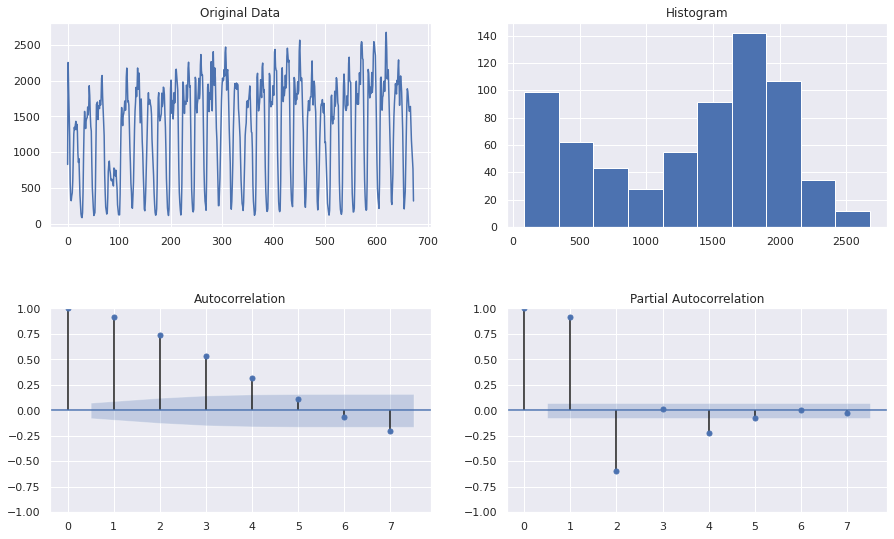

Test for Stationarity:
ADF Statistic: -3.168862
p-value: 0.021859
******************************
Plotting the stats for Brooklyn


/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



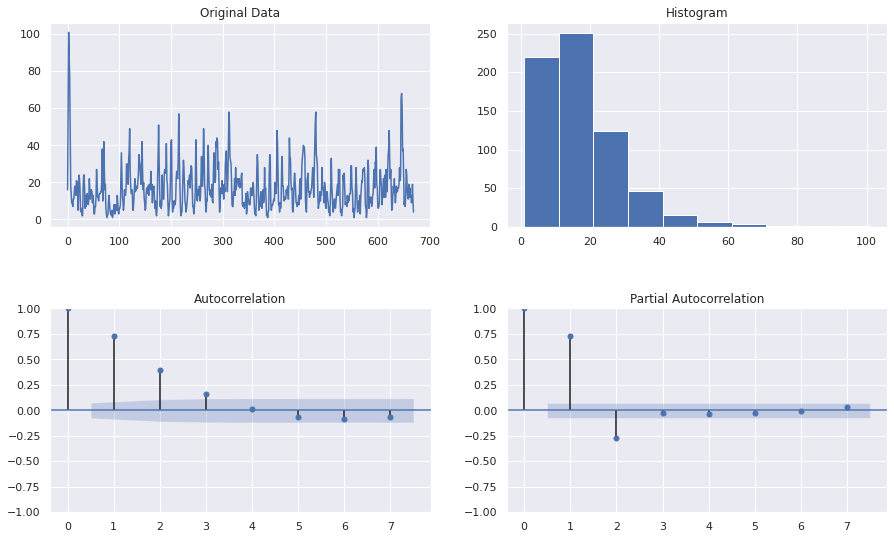

Test for Stationarity:
ADF Statistic: -5.058592
p-value: 0.000017
******************************
Plotting the stats for Queens


/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



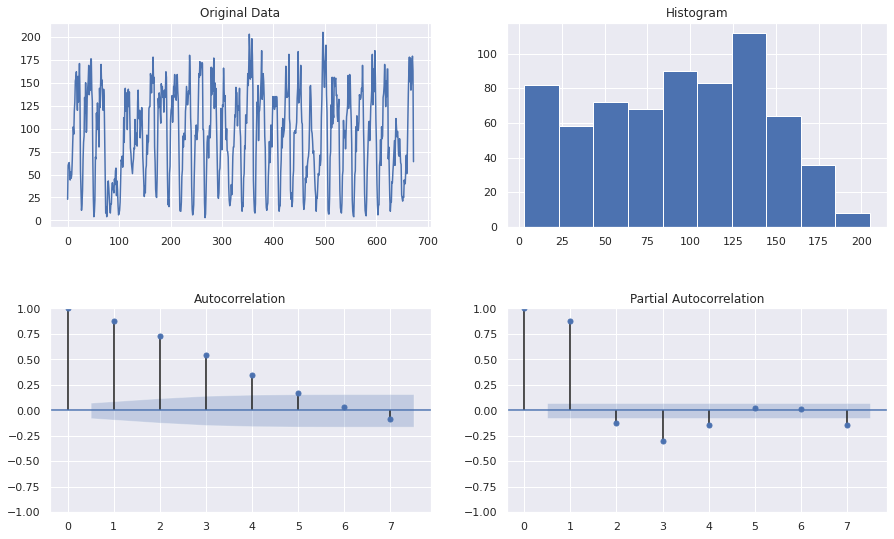

Test for Stationarity:
ADF Statistic: -3.214536
p-value: 0.019159
******************************


In [ ]:
plot_stats_pickups(Borough_pickups_arima)

* We consider lag to be for 7 days and see the behaviour of the graph.
* We can see that ACF graph gradually decreases while there is a sudden spike in the PACF graph, which means that AR term is dominant to MA term.

*We create a function which divides the data into train and test and create predicitons*

In [ ]:
def ARIMA_forecasting(dataset):
	def plot(test, predictions):
		fig, ax = plt.subplots(3,1,figsize=(10,18))
		i=0
		for Borough in test:
			ax[i].plot(test[Borough], label="Actual_Demand")
			ax[i].plot(predictions[Borough], label="Predicted_Demand")
			ax[i].set_title(f"Actual vs forcasted for {Borough}")
			res=mean_absolute_percentage_error(test[Borough], predictions[Borough])
			print(f"MAPE for {Borough}:{res}")
			print("*"*30)
			i+=1
		plt.show()
	
	test={}
	train={}
	predictions={}
	orders=[(7,1,0),(1,1,0),(2,1,0)]
	j=0
	for Borough in dataset:
		X = dataset[Borough]['hourly_demand'].values
		size = 503
		train[Borough], test[Borough] = X[0:size], X[size:]
		test[Borough]=[x for x in test[Borough]]
		history = [x for x in train[Borough]]
		predictions[Borough] = []
		for t in range(len(test[Borough])):
			model = ARIMA(history,order=orders[j])
			model_fit = model.fit()
			output= model_fit.forecast()
			yhat = output[0]
			predictions[Borough].append(yhat)
			obs = test[Borough][t]
			history.append(obs)
		j+=1
	plot(test, predictions)

MAPE for Manhattan:0.17410508180802464
******************************
MAPE for Brooklyn:0.5745879239635229
******************************
MAPE for Queens:0.3411555451615653
******************************


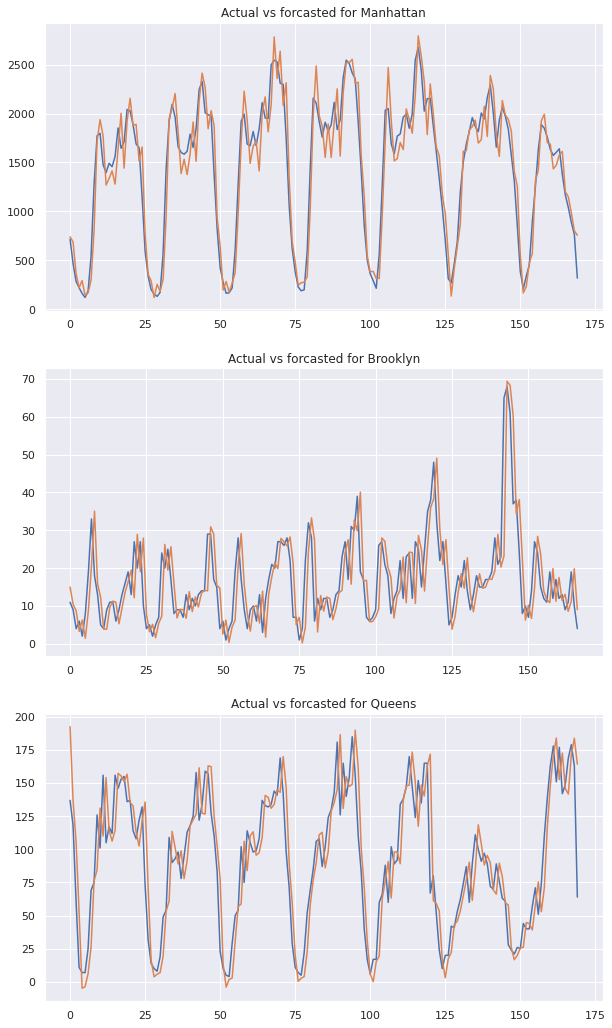

In [ ]:
ARIMA_forecasting(Borough_pickups_arima)

* We try different models to predict the values. Finetuning is still necessary but we do get a good result for manhattan from ARIMA model.
* Next we try the facebook's prophet model which is supposed to handle seasonalities well and see its behavior.

## FB Prophet model

* Similarly, we divide the data into different boroughs for prophet as well.

In [ ]:
Boroughs=['Manhattan','Brooklyn','Queens']
Borough_pickups_prophet={}
for Borough in Boroughs:
  Borough_pickups_prophet[Borough]= merged_doc[merged_doc['Pickup_Borough']==Borough]
  Borough_pickups_prophet[Borough]= Borough_pickups_prophet[Borough].assign(pickup_datetime=Borough_pickups_prophet[Borough].pickup_datetime.dt.round('H'))
  Borough_pickups_prophet[Borough]= Borough_pickups_prophet[Borough].groupby(['pickup_datetime']).agg({'passenger_count':'count'})
  Borough_pickups_prophet[Borough].columns=['y']
  Borough_pickups_prophet[Borough]=Borough_pickups_prophet[Borough].reset_index()
  Borough_pickups_prophet[Borough]=Borough_pickups_prophet[Borough].rename(columns={'pickup_datetime':'ds'})

* We create a function to do a forecasting with the prophet model

In [ ]:
def fb_prophet_forecasting(dataset,size=504):
  def plot_res(y_actual, y_pred, br):
    print(f"PLotting the results for {br}")
    print(f"MAPE:{mean_absolute_percentage_error(y_actual,y_pred)}")
    fig,ax= plt.subplots(1,1,figsize=(10,6))
    ax.plot(y_actual, label="Actual_Demand")
    ax.plot(y_pred, label="Predicted_Demand")
    ax.set_title(f"Actual vs forcasted for {br}")
    plt.show()
    print("*"*40)
  for Borough in dataset:
    train,test= dataset[Borough][:size], dataset[Borough][size:]
    train_len= len(train)
    test_len=len(test)
    prophet_model= Prophet(yearly_seasonality=False,weekly_seasonality=True)
    prophet_model.fit(train)
    future=prophet_model.make_future_dataframe(periods=len(test),freq='H',include_history=False)
    preds= prophet_model.predict(future)
    test=test.reset_index()
    plot_res(test['y'], preds['yhat'],Borough)


PLotting the results for Manhattan
MAPE:0.4219419240631084


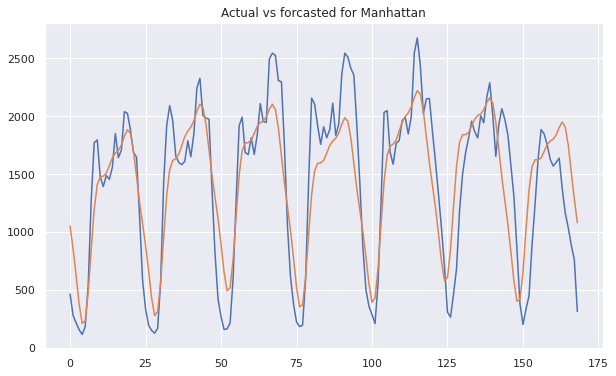

****************************************
PLotting the results for Brooklyn
MAPE:0.7459099303658295


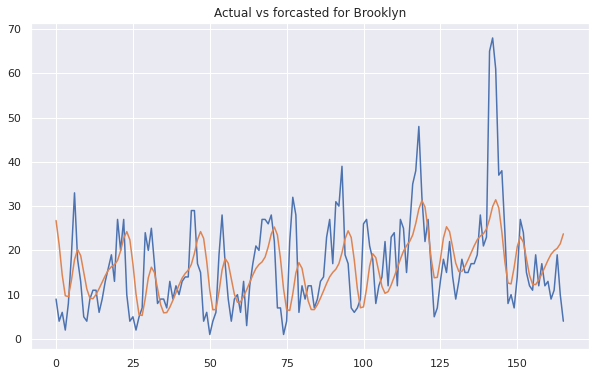

****************************************
PLotting the results for Queens
MAPE:0.49624168148713566


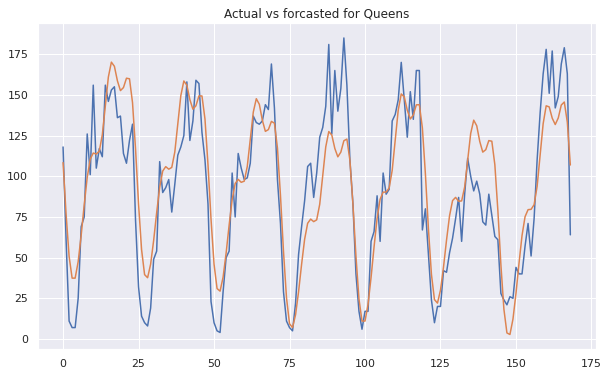

****************************************


In [ ]:
fb_prophet_forecasting(Borough_pickups_prophet)

* As you can see, prophet is able to capture the basic trend and seasonality but doesnt capture the residual values. 
* Naturally the predicitons weren't too great with MAPE being bad for all the Boroughs.

*Next we will try LSTM and see its behavior for predictions*

## Using LSTM for predictions

* We segregate the data for the boroughs and add features to help with the predictions.
* sin_day, cos_day, sin_hour and cos_hour can be good features as they help us combine hours across and days together which show similar demands(as seen from the graph).



In [22]:
#create different dataframes for the different boroughs

Boroughs=['Manhattan','Brooklyn','Queens']
Borough_pickups_lstm={}
for Borough in Boroughs:
  Borough_pickups_lstm[Borough]= merged_doc[merged_doc['Pickup_Borough']==Borough]
  Borough_pickups_lstm[Borough]= Borough_pickups_lstm[Borough].assign(pickup_datetime=Borough_pickups_lstm[Borough].pickup_datetime.dt.round('H'))
  Borough_pickups_lstm[Borough]= Borough_pickups_lstm[Borough].groupby(['pickup_datetime']).agg({'passenger_count':'count'})
  Borough_pickups_lstm[Borough].columns=['hourly_demand']
  Borough_pickups_lstm[Borough]=Borough_pickups_lstm[Borough].reset_index()

In [23]:
#adding features like cos_day, sin_day, cos_hour, sin_hour
for Borough in Borough_pickups_lstm:
  Borough_pickups_lstm[Borough]['sin_day']=np.sin(2*np.pi*Borough_pickups_lstm[Borough].pickup_datetime.dt.dayofweek/7)
  Borough_pickups_lstm[Borough]['cos_day']=np.cos(2*np.pi*Borough_pickups_lstm[Borough].pickup_datetime.dt.dayofweek/7)
  Borough_pickups_lstm[Borough]['cos_hour']=np.cos(2*np.pi*Borough_pickups_lstm[Borough].pickup_datetime.dt.hour/24)
  Borough_pickups_lstm[Borough]['sin_hour']=np.sin(2*np.pi*Borough_pickups_lstm[Borough].pickup_datetime.dt.hour/24)
  Borough_pickups_lstm[Borough].index= Borough_pickups_lstm[Borough]['pickup_datetime']
  Borough_pickups_lstm[Borough].pop('pickup_datetime')

* We divide the dataset into train and test and use Robust scalar to make the features on the same scale. This is important for the performace since the values for the weight matrices depend on the magnitude of the features and we imbalance in the values. (the matrix values being really high or low)

In [24]:
train={}
test={}
for Borough in Borough_pickups_lstm:
  train[Borough]=Borough_pickups_lstm[Borough][Borough_pickups_lstm[Borough].index<='2018-01-21 23:00:00'].copy()
  test[Borough]= Borough_pickups_lstm[Borough][Borough_pickups_lstm[Borough].index>'2018-01-21 23:00:00'].copy()
  features=['sin_hour','cos_hour','sin_day','cos_day']
  feature_transformer=RobustScaler()
  HD_transformer=RobustScaler()
  feature_transformer = feature_transformer.fit(train[Borough][features].to_numpy())
  HD_transformer = HD_transformer.fit(train[Borough][['hourly_demand']])
  train[Borough].loc[:,features] = feature_transformer.transform(train[Borough][features].to_numpy())
  test[Borough].loc[:,features] = feature_transformer.transform(test[Borough][features].to_numpy())
  train[Borough]['hourly_demand'] = HD_transformer.transform(train[Borough][['hourly_demand']])
  test[Borough]['hourly_demand'] = HD_transformer.transform(test[Borough][['hourly_demand']])

* As we want to use LSTMs, we need to create data into (a,b,c) format where:
1. a= batch size
2. b= number of previous points to consider.
3. c= number of features.

In [25]:
def create_dataset(data,y_col,option, time_steps):
  X={}
  Y={}
  if option =="All of NYC":
    for Borough in data:
      Xs, ys = [], []
      for i in range(len(data[Borough]) - time_steps):
          v = data[Borough].iloc[i:(i + time_steps)].values
          Xs.append(v)        
          ys.append(data[Borough][y_col].iloc[i + time_steps])
      Xs=np.array(Xs)
      Ys=np.array(ys)
      X[Borough]=Xs
      Y[Borough]=Ys
  else:
    Xs, ys = [], []
    for i in range(len(data[option]) - time_steps):
        v = data[option].iloc[i:(i + time_steps)].values
        Xs.append(v)        
        ys.append(data[option][y_col].iloc[i + time_steps])
    Xs=np.array(Xs)
    Ys=np.array(ys)
    X[option]=Xs
    Y[option]=Ys
  return X,Y

In [26]:
X_train, Y_train= create_dataset(train,'hourly_demand','All of NYC',12)
X_test, Y_test= create_dataset(test,'hourly_demand','All of NYC',12)

* We create a train LSTM function and which takes the input, output, batch size, validation split and shuffle parameters as input. 
* You have to note here that you should not shuffle your data while predicting because in real life you would be getting data sequentially and you will need to process it that way.

In [29]:
def train_LSTM(X,Y,option,epochs=30,batch_size=16,validation_split=0.1,verbose=0,shuffle=False):
  def train_model(x,y,epochs=30,batch_size=16,validation_split=0.1,verbose=0,shuffle=False):
      model = Sequential()
      model.add(Bidirectional(LSTM(units=50, input_shape=(x.shape[1], x.shape[2]))))
      model.add(Dense(units=1))
      model.compile(loss='mse', optimizer='adam')
      history = model.fit(x, y, epochs=epochs, batch_size=batch_size, validation_split=validation_split, verbose=verbose, shuffle=False)
      return history, model
  models={}
  if option=="All of NYC":
    i=0
    fig, ax = plt.subplots(len(X.keys()),1,figsize=(10,10))
    for Borough in X:
      history, model=train_model(X[Borough],Y[Borough])
      models[Borough]=model
      ax[i].plot(history.history['loss'],label="Training Loss")
      ax[i].plot(history.history['val_loss'],label="Validation Loss")
      ax[i].set_title(f"Training LSTM on data for {Borough} Borough")
      ax[i].legend()
      i+=1
  else:
    fig, ax = plt.subplots(1,1,figsize=(10,3))
    history,model=train_model(X[option],Y[option])
    ax.plot(history.history['loss'],label="Training Loss")
    ax.plot(history.history['val_loss'],label="Validation Loss")
    ax.set_title(f"Training LSTM on data for {option} Borough")
    ax.legend()
    models[option]=model
  return models

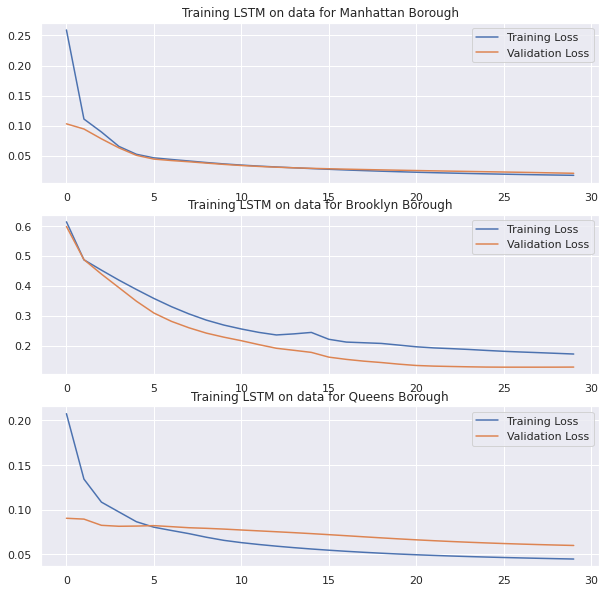

In [31]:
models=train_LSTM(X_train,Y_train,'All of NYC')

In [32]:
def predict_and_score(X,y,models,option):
  y_pred=models[option].predict(X[option])
  y_pred_unscaled=HD_transformer.inverse_transform(y_pred)
  y=np.expand_dims(y[option],axis=1)
  y_unscaled=HD_transformer.inverse_transform(y)
  print(f"MAPE: {mean_absolute_percentage_error(y_unscaled,y_pred_unscaled)}")
  x=np.arange(len(y_pred))
  fig, ax = plt.subplots(1,1,figsize=(10,6))
  ax.plot(x,y_unscaled,label="Original data")
  ax.plot(x,y_pred_unscaled,label="Predictions")
  ax.legend()
  ax.set_title(f"Plot of Actual vs Predicted for {option}")
  return y_pred_unscaled,y_unscaled

MAPE: 0.14191530138782968


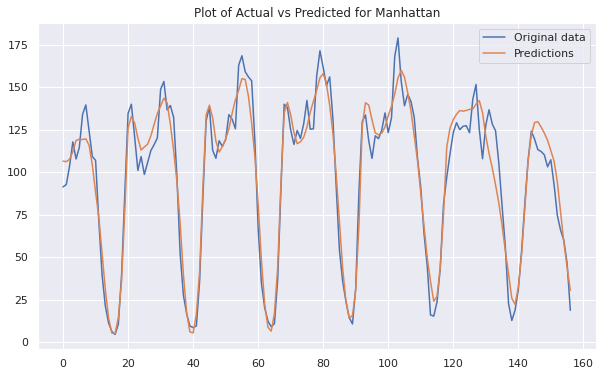

In [33]:
y_pred,y_unscaled=predict_and_score(X_test,Y_test,models,'Manhattan')

MAPE: 0.31529970831055504


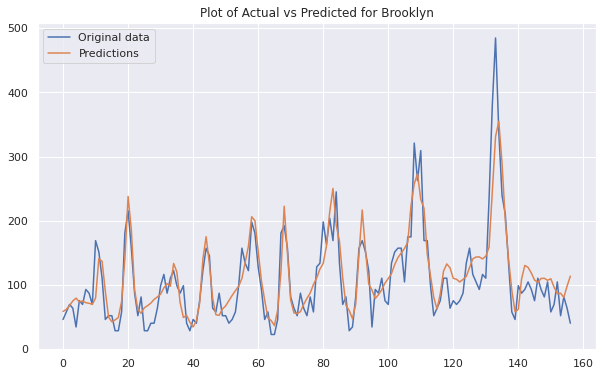

In [34]:
y_pred,y_unscaled=predict_and_score(X_test,Y_test,models,'Brooklyn')

MAPE: 0.22668144639990376


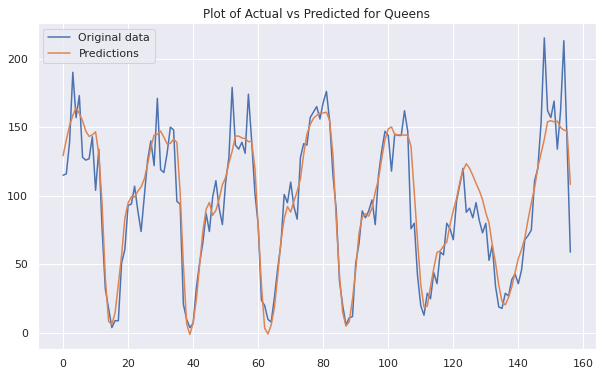

In [35]:
y_pred,y_unscaled=predict_and_score(X_test,Y_test,models,'Queens')

* As you can see LSTM performs well on the dataset with MAPE for Manhattan being around .14 while that of Brooklyn and Queens being around .31 and .22

## Using Random Forest Regressor to train the data (Left for other 2 boroughs)

* Next we try using Random forest regressor to compare its performance to earlier models.

In [71]:
from sklearn.ensemble import RandomForestRegressor

* We will be using same features as LSTM to train our Random forest as well. So we just create train and test datasets to assist with training and validation from previously created dataset
* To use radom forest regressor, we need to convert it into a supervised learning problem with lags. So we use the strategy used earlier to create lags, but instead of adding features we just create dataset with past demand and try to predict the next one.

In [72]:
Boroughs=['Manhattan','Brooklyn','Queens']
Borough_pickups_lstm={}
for Borough in Boroughs:
  Borough_pickups_lstm[Borough]= merged_doc[merged_doc['Pickup_Borough']==Borough]
  Borough_pickups_lstm[Borough]= Borough_pickups_lstm[Borough].assign(pickup_datetime=Borough_pickups_lstm[Borough].pickup_datetime.dt.round('H'))
  Borough_pickups_lstm[Borough]= Borough_pickups_lstm[Borough].groupby(['pickup_datetime']).agg({'passenger_count':'count'})
  Borough_pickups_lstm[Borough].columns=['hourly_demand']
  Borough_pickups_lstm[Borough]=Borough_pickups_lstm[Borough].reset_index()
for Borough in Borough_pickups_lstm:
  Borough_pickups_lstm[Borough]['sin_day']=np.sin(2*np.pi*Borough_pickups_lstm[Borough].pickup_datetime.dt.dayofweek/7)
  Borough_pickups_lstm[Borough]['cos_day']=np.cos(2*np.pi*Borough_pickups_lstm[Borough].pickup_datetime.dt.dayofweek/7)
  Borough_pickups_lstm[Borough]['cos_hour']=np.cos(2*np.pi*Borough_pickups_lstm[Borough].pickup_datetime.dt.hour/24)
  Borough_pickups_lstm[Borough]['sin_hour']=np.sin(2*np.pi*Borough_pickups_lstm[Borough].pickup_datetime.dt.hour/24)
  Borough_pickups_lstm[Borough].index= Borough_pickups_lstm[Borough]['pickup_datetime']
  Borough_pickups_lstm[Borough].pop('pickup_datetime')

In [73]:
train, test={},{}
for borough in Borough_pickups_lstm:
  train[borough]=Borough_pickups_lstm[borough][Borough_pickups_lstm[borough].index<='2018-01-21 23:00:00'].copy()
  test[borough]= Borough_pickups_lstm[borough][Borough_pickups_lstm[borough].index>'2018-01-21 23:00:00'].copy()

In [74]:
def create_dataset(data,y_col,option, time_steps):
  X={}
  Y={}
  if option =="All of NYC":
    for Borough in data:
      Xs, ys = [], []
      for i in range(len(data[Borough]) - time_steps):
          v = data[Borough][y_col].iloc[i:(i + time_steps)].values
          Xs.append(v)        
          ys.append(data[Borough][y_col].iloc[i + time_steps])
      Xs=np.array(Xs)
      Ys=np.array(ys)
      X[Borough]=Xs
      Y[Borough]=Ys
  else:
    Xs, ys = [], []
    for i in range(len(data[option]) - time_steps):
        v = data[option][y_col].iloc[i:(i + time_steps)].values
        Xs.append(v)        
        ys.append(data[option][y_col].iloc[i + time_steps])
    Xs=np.array(Xs)
    Ys=np.array(ys)
    X[option]=Xs
    Y[option]=Ys
  return X,Y

In [75]:
X_train, Y_train= create_dataset(train,'hourly_demand','All of NYC',12)
X_test, Y_test= create_dataset(test,'hourly_demand','All of NYC',12)

*Predicting for Manhattan*

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:   17.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.1s finished


0.09226117386718405


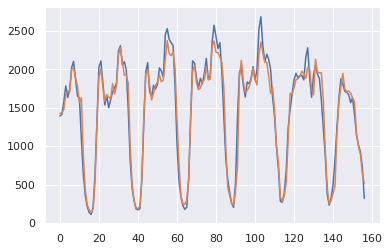

In [76]:
reg=RandomForestRegressor(n_estimators=1000,criterion='absolute_error',verbose=1)
reg.fit(X_train['Manhattan'],Y_train['Manhattan'])
Y_pred=reg.predict(X_test['Manhattan'])
Y_pred=np.expand_dims(Y_pred,axis=1)
Y_pred= [int(y) for y in Y_pred]
plt.plot(Y_test['Manhattan'],label="Original data")
plt.plot(Y_pred,label="Predictions")
print(f"MAPE: {mean_absolute_percentage_error(Y_test['Manhattan'],Y_pred)}")

*Predicting for Brooklyn*

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    3.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.1s finished


MAPE: 0.4529309670456439


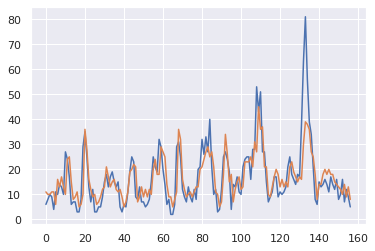

In [84]:
reg=RandomForestRegressor(n_estimators=1000,criterion='squared_error',verbose=1)
reg.fit(X_train['Brooklyn'],Y_train['Brooklyn'])
Y_pred=reg.predict(X_test['Brooklyn'])
Y_pred=np.expand_dims(Y_pred,axis=1)
Y_pred= [int(y) for y in Y_pred]
plt.plot(Y_test['Brooklyn'],label="Original data")
plt.plot(Y_pred,label="Predictions")
print(f"MAPE: {mean_absolute_percentage_error(Y_test['Brooklyn'],Y_pred)}")

*Predicting for Queens*

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    3.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.1s finished


MAPE: 0.27406441061718145


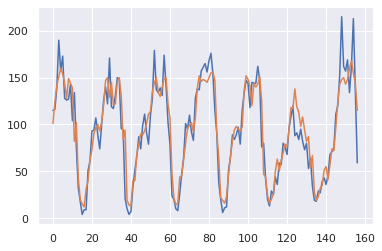

In [82]:
reg=RandomForestRegressor(n_estimators=1000,criterion='squared_error',verbose=1)
reg.fit(X_train['Queens'],Y_train['Queens'])
Y_pred=reg.predict(X_test['Queens'])
Y_pred=np.expand_dims(Y_pred,axis=1)
Y_pred= [int(y) for y in Y_pred]
plt.plot(Y_test['Queens'],label="Original data")
plt.plot(Y_pred,label="Predictions")
print(f"MAPE: {mean_absolute_percentage_error(Y_test['Queens'],Y_pred)}")

* As we can see, Random forest performed really well for Manhattan, with MAPE as less as .09. 
* As for Brooklyn and Queens The model did fairly well to match the trend, but could not capture the inconsistancies.

## XG Boost Regressor

* Similar to random forest, xgboost regressor also needs the data to be converted into supervised learning problem, so we use the train and test splits created before.
* We just feed the data to the regressor to fit and then use the test set to create predictions. 
The results are shown below.

In [86]:
from xgboost import XGBRegressor

*Predicting for Manhattan*

[15:15:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MAPE: 0.09535107114114061


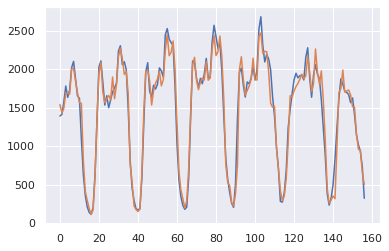

In [89]:
reg=XGBRegressor(n_estimators=1000,criterion='absolute_error',verbose=1)
reg.fit(X_train['Manhattan'],Y_train['Manhattan'])
pred=reg.predict(X_test['Manhattan'])
plt.plot(Y_test['Manhattan'])
plt.plot(pred)
print(f"MAPE: {mean_absolute_percentage_error(Y_test['Manhattan'],pred)}")

*Predicting for Brooklyn*

[15:18:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MAPE: 0.494904110796482


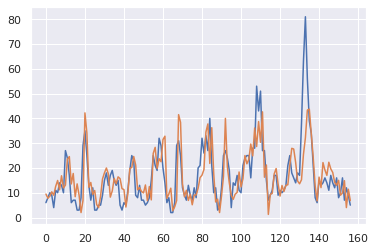

In [93]:
reg=XGBRegressor(n_estimators=1000,criterion='squared_error',verbose=0)
reg.fit(X_train['Brooklyn'],Y_train['Brooklyn'])
pred=reg.predict(X_test['Brooklyn'])
plt.plot(Y_test['Brooklyn'])
plt.plot(pred)
print(f"MAPE: {mean_absolute_percentage_error(Y_test['Brooklyn'],pred)}")

*Predicting for Queens*

[15:29:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MAPE: 0.2808668945667111


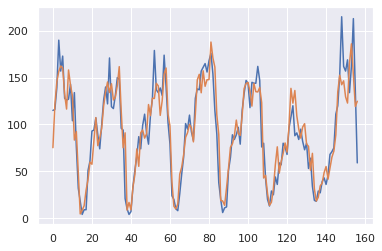

In [95]:
reg=XGBRegressor(n_estimators=1000,criterion='squared_error',verbose=1)
reg.fit(X_train['Queens'],Y_train['Queens'])
pred=reg.predict(X_test['Queens'])
plt.plot(Y_test['Queens'])
plt.plot(pred)
print(f"MAPE: {mean_absolute_percentage_error(Y_test['Queens'],pred)}")

## Final thoughts and conclusions

In [103]:
index=["ARIMA","Prophet","LSTM","Random forest","XGBoost"]
mape_df={'Manhattan':[.17,.42,.14,.092,.095],'Brooklyn':[.57,.745,.31,.452,.49],'Queens':[.34,.49,.22,.274,.280]}
mape_df=pd.DataFrame.from_dict(mape_df)
mape_df.index=index

In [104]:
mape_df

,Manhattan,Brooklyn,Queens
ARIMA,0.170,0.570,0.340
Prophet,0.420,0.745,0.490
LSTM,0.140,0.310,0.220
Random forest,0.092,0.452,0.274
XGBoost,0.095,0.490,0.280


* The above table shows a comparative for MAPE for all the prediction models for different boroughs.
* In our case, both random forest and xgboost performed really well on the manhattan dataset with MAPE being as low as .09. This was followed by LSTM then ARIMA and prophet failed to capture all the details and more reseasrch might be needed to improve its performance.
* For brooklyn, LSTM was the best but none of the models performed to well as the data had sudden surge of demand that the model could not predict given the limited data that was provided to it. However, most of the models were able to capture the basic trend and could easily help in making informed decisions for the drivers. The data for brooklyn also did not have any specific repeating pattern so models performing not that great is expected. 
*  As for Queens, models did fairly well owing to the repeating trends except accounting for the sudden surge in demand in the last couple of days of the final week.
* This comprehensive study helps in understanding the limitation of prediction models but still gives us a very good idea as to how data science can be used to help the drivers in making informed decisions to capture the maximum demand

# **THE END**